## 卡尔曼滤波行人状态估计

来自博客https://adamshan.blog.csdn.net/article/details/78248421

首先我们看一下卡尔曼滤波的整个流程，其实在实际的论文和资料中，预测矩阵通常使用  F 来表示,测量矩阵通常使用 H  表示（,卡尔曼增益通常使用 K 来表示,下面是文献材料中通常意义的卡尔曼滤波过程：

![](https://imgconvert.csdnimg.cn/aHR0cDovL2ltZy5ibG9nLmNzZG4ubmV0LzIwMTcxMDE2MTIyNzUxMTk3?x-oss-process=image/format,png)


注意：公式还包含一项： B μ  ,这一项是指我们在追踪一个物体的状态的时候把它内部的控制也考虑进去了，这在行人，自行车，其他汽车的状态估计问题中是无法测量的，所以在这个问题中我们设置 B μ 为 0.


载入库

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


接着我们初始化行人状态x, 行人的不确定性（协方差矩阵）P，测量的时间间隔dt，处理矩阵F以及测量矩阵H：

In [2]:
x = np.matrix([[0.0,0.0,0.0,0.0]]).T 
P = np.diag([1000.0,1000.0,1000.0,1000.0])

dt = 0.1  # 滤波步长

F = np.matrix([[1.0, 0.0, dt, 0.0],
        [0.0, 1.0, 0.0, dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

H = np.matrix([[0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])




计算测量过程的噪声的协方差矩阵R和过程噪声的协方差矩阵Q：

In [3]:

ra = 0.09
R = np.matrix([[ra, 0.0],
        [0.0, ra]])
print(R, R.shape)

sv = 0.5
G = np.matrix([[0.5*dt**2],
        [0.5*dt**2],
        [dt],
        [dt]])
Q = G*G.T*sv**2



[[0.09 0.  ]
 [0.   0.09]] (2, 2)


定义一个单位矩阵：

In [4]:
I = np.eye(4)
print(I, I.shape)


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


随机生成一些数据


(2, 200)
Standard Deviation of Acceleration Measurements=1.02
You assumed 0.09 in R.


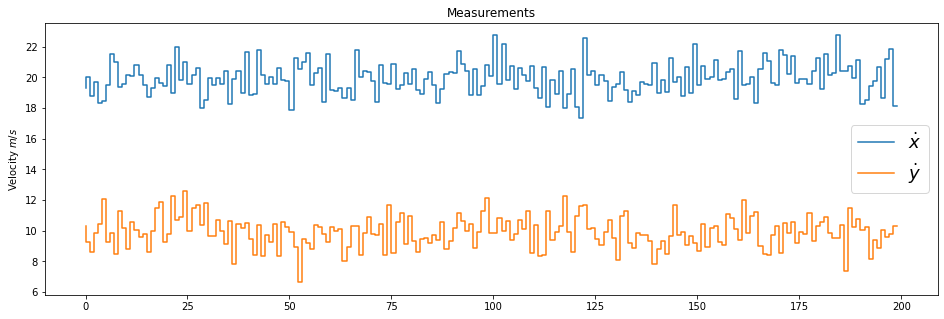

In [5]:
m = 200  # Measurements
vx = 20  # in X
vy = 10  # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))
measurements = np.vstack((mx, my))

print(measurements.shape)
print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0, 0])

fig = plt.figure(figsize=(16, 5))
plt.step(range(m), mx, label='$\dot x$')
plt.step(range(m), my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best', prop={'size': 18})


结果值保存

In [6]:
xt = []
yt = []
dxt = []
dyt = []
Zx = []
Zy = []
Px = []
Py = []
Pdx = []
Pdy = []
Rdx = []
Rdy = []
Kx = []
Ky = []
Kdx = []
Kdy = []


def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0, 0]))
    Py.append(float(P[1, 1]))
    Pdx.append(float(P[2, 2]))
    Pdy.append(float(P[3, 3]))
    Rdx.append(float(R[0, 0]))
    Rdy.append(float(R[1, 1]))
    Kx.append(float(K[0, 0]))
    Ky.append(float(K[1, 0]))
    Kdx.append(float(K[2, 0]))
    Kdy.append(float(K[3, 0]))


卡尔曼滤波：

In [7]:
for n in range(len(measurements[0])):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = F*x

    # Project the error covariance ahead
    P = F*P*F.T + Q

    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    # Update the estimate via z
    Z = measurements[:, n].reshape(2, 1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*H))*P

    # Save states (for Plotting)
    savestates(x, Z, P, R, K)


关于速度的估计结果：

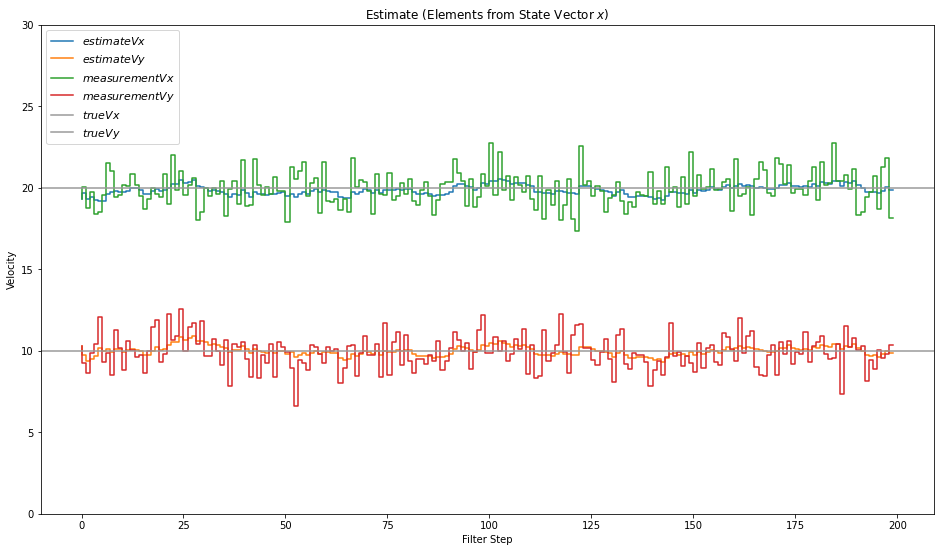

In [8]:
def plot_x():
    fig = plt.figure(figsize=(16, 9))
    plt.step(range(len(measurements[0])), dxt, label='$estimateVx$')
    plt.step(range(len(measurements[0])), dyt, label='$estimateVy$')

    plt.step(range(len(measurements[0])),
             measurements[0], label='$measurementVx$')
    plt.step(range(len(measurements[0])),
             measurements[1], label='$measurementVy$')

    plt.axhline(vx, color='#999999', label='$trueVx$')
    plt.axhline(vy, color='#999999', label='$trueVy$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best', prop={'size': 11})
    plt.ylim([0, 30])
    plt.ylabel('Velocity')


plot_x()


位置的估计结果：

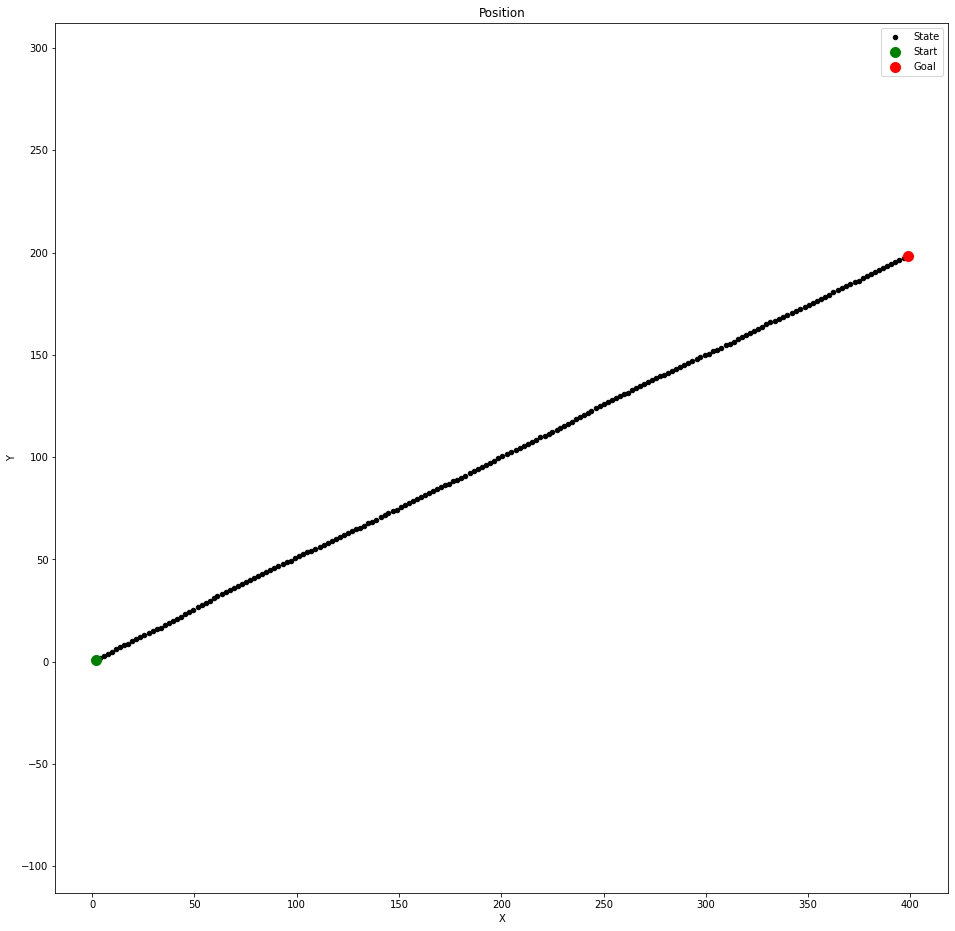

In [9]:
def plot_xy():
    fig = plt.figure(figsize=(16, 16))
    plt.scatter(xt, yt, s=20, label='State', c='k')
    plt.scatter(xt[0], yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1], yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')


plot_xy()
